In [67]:
import pandas as pd
import numpy as np
import pyarrow
import seaborn as sns
import statsmodels.api as sm
from pysal.model import spreg
from pysal.lib import weights
from scipy import stats
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import osmnx as ox
import libpysal
import time
from geopy.geocoders import Nominatim
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [68]:
# import csv file
ev_df = pd.read_csv('data/Cleaned data/ev_df_copy.csv')

In [69]:
ev_df

,Year,Quarter,ITL level 1,Number of car models,Sum of Chargepoints,population,Number of vehicles,Average variable unit price (£/kWh),ULSP: Pump price (p/litre),ULSD: Pump price (p/litre),NQF level 4 or above,NQF level 3 or above,NQF level 2 or above,gdhi
0,2010,1,Scotland,2.0,0,1.899124e+05,7.453333e+02,0.117261,116.904146,119.234615,37.0,58.0,77.0,15752.130435
1,2010,1,Northern Ireland,2.0,0,1.609992e+05,7.453333e+02,0.147227,116.904146,119.234615,31.0,51.0,71.0,13477.090909
2,2010,1,London,2.0,0,9.970620e+04,7.453333e+02,0.112747,116.904146,119.234615,38.0,59.0,78.0,23079.333333
3,2010,1,Yorkshire and The Humber,2.0,0,3.441465e+05,9.123333e+02,0.110018,116.904146,119.234615,38.0,59.0,78.0,14153.727273
4,2010,1,East of England,2.0,0,5.541227e+04,1.950000e+01,0.106334,116.904146,119.234615,38.0,59.0,78.0,16421.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2020,4,North West,29.0,54643,1.358377e+07,2.231069e+06,0.169144,114.092268,119.455858,47.0,66.0,83.0,19009.200000
496,2020,4,South West,29.0,55338,1.370596e+07,2.321926e+06,0.178331,114.092268,119.455858,47.0,66.0,83.0,20829.166667
497,2020,4,Wales,29.0,55423,1.372389e+07,2.326232e+06,0.179522,114.092268,119.455858,41.0,61.0,81.0,17571.250000
498,2020,4,North East,29.0,54436,1.354345e+07,2.208026e+06,0.166792,114.092268,119.455858,47.0,66.0,83.0,17577.833333


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17126D+01    |proj g|=  1.74179D+00

At iterate    5    f=  1.15695D+01    |proj g|=  6.77818D-02

At iterate   10    f=  1.15410D+01    |proj g|=  1.45071D-02

At iterate   15    f=  1.15390D+01    |proj g|=  1.40403D-01

At iterate   20    f=  1.13522D+01    |proj g|=  1.01261D+00

At iterate   25    f=  1.12982D+01    |proj g|=  4.56649D-01

At iterate   30    f=  1.12956D+01    |proj g|=  4.75625D-04

At iterate   35    f=  1.12952D+01    |proj g|=  3.17357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

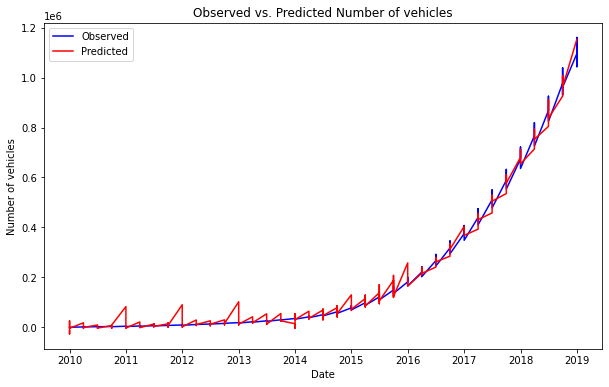

In [70]:
# Create a datetime index based on 'Year' and 'Quarter' columns
ev_df['Date'] = pd.to_datetime(ev_df['Year'].astype(str) + 'Q' + ev_df['Quarter'].astype(str))
ev_df.set_index('Date', inplace=True)

# Define your dependent variable and explanatory variables
dependent_var = 'Number of vehicles'
explanatory_vars = ['population', 'Average variable unit price (£/kWh)',
                    'Sum of Chargepoints', 'Number of car models']

# split into train/test datasets
train_df = ev_df[:'2019-03-31']
test_df = ev_df['2019-04-01':]

# Fit the SARIMAX model
endog = train_df[dependent_var]
exog = train_df[explanatory_vars]
sarimax_model = SARIMAX(endog, exog=exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))
sarimax_result = sarimax_model.fit()

# Print the summary of the SARIMAX model
print(sarimax_result.summary())


# Get the predicted values from the SARIMAX model
predicted_values = sarimax_result.predict(start=exog.index[0], end=exog.index[-1], exog=exog)

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog.index, endog, label='Observed', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


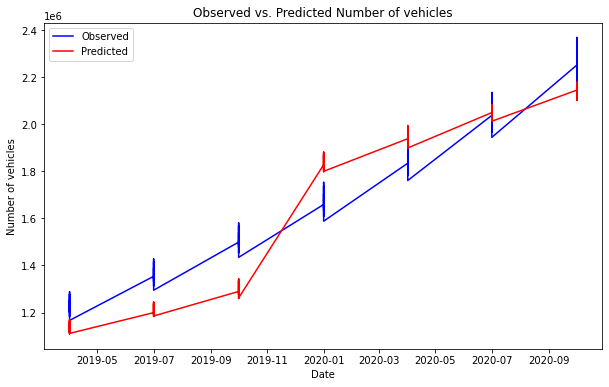

In [54]:

endog_test = test_df[dependent_var]
exog_test = test_df[explanatory_vars]

predicted_values = sarimax_result.forecast(84, exog=test_df[explanatory_vars])
predicted_values.index = test_df.index

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog_test.index, endog_test, label='Observed', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()

In [60]:


# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(endog_test, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(endog_test, predicted_values)

print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")



R-squared (R2 ): 0.8451896666053208
Mean Squared Error (MSE): 18731798862.5227
Root Mean Squared Error (RMSE): 136864.16208241915
